# Getting Radius of Curvature from Images

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy.optimize import curve_fit
from scipy      import optimize
import seaborn as sns
import pandas
from scipy import integrate
import imutils
from imutils import perspective
from imutils import contours

sns.set_context('notebook',font_scale=1.5)
sns.set_style(style='whitegrid')

%matplotlib inline

In [9]:
def extract_radius_of_curvature(image_path):
    # Load an color image in grayscale
    img = cv2.imread(image_path,0)
    # Blur image 
    blurred = cv2.GaussianBlur(img, (5,5), 0)
    # Detect Edges
    edges = cv2.Canny(blurred,30,100)
    edges = cv2.dilate(edges, None, iterations=1)
    edges = cv2.erode(edges, None, iterations=1)
    
    # find contours in the edge map
    cnts = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    
    (cnts, _) = contours.sort_contours(cnts)
    
    ############################################ Plotting ###############################################################
    plt.figure(figsize=(25,7))
    
    plt.subplot(131)
    plt.imshow(img,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(132),plt.imshow(edges,cmap = 'viridis')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    
    # makes copy of the original image
    orig = img.copy()
    plt.subplot(133),plt.imshow(orig,cmap = 'viridis')
    plt.title('Fitted Circles'), plt.xticks([]), plt.yticks([])
    
    ################################ loop over the contours individually####################################################
    radius_of_curvature = []
    text_x = []
    text_y = []
    for c in cnts:
        # if the contour is not sufficiently large, ignore it
        if cv2.contourArea(c) < 100:
            continue
        # gets the x and y values and makes a list of them seperately
        x = np.array(c)[:,0,0]
        y = np.array(c)[:,0,1]
        # Get the center of each contour to use as the first guest to determine the center point of the circle
        M = cv2.moments(c)
        x_m = int(M["m10"] / M["m00"])
        text_x.append(x_m-100)
        y_m = int(M["m01"] / M["m00"])
        text_y.append(y_m)
        center_estimate = x_m, y_m
        ####### DEFINE FUNCS ###########
        def calc_R(xc, yc):
            #calculate the distance of each 2D points from the center (xc, yc)
            return np.sqrt((x-xc)**2 + (y-yc)**2)

        def f_2(c):
            #calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc)
            Ri = calc_R(*c)
            return Ri - Ri.mean()
        ##################################
        # use the x,y listed above and center_estimate to fit circle to arcs
        center_2, ier = optimize.leastsq(f_2, center_estimate)
        xc_2, yc_2 = center_2
        Ri_2       = calc_R(*center_2)
        # average all the radii to get mean radius for each ar
        R_2 = Ri_2.mean()
        radius_of_curvature.append(R_2)
        # draw circle on image
        cv2.circle(orig,(int(xc_2),int(yc_2)), int(R_2), (255,0,0), 3)
        
    # Normalize the radii by the dot size
    R_dot = 3 # mm
    R_ratio = R_dot/R_2
    R = []
    for r in radius_of_curvature:
        rr = r*R_ratio
        R.append(rr)
    #print(R)
    for x,y,r in zip(text_x,text_y,R):
        plt.text(x,y,'R = ' + str(round(r,2)) + 'mm',
        fontsize=16, color='white')
        
    return orig, 

(292, 1, 2)
(266, 1, 2)
(623, 1, 2)
(723, 1, 2)


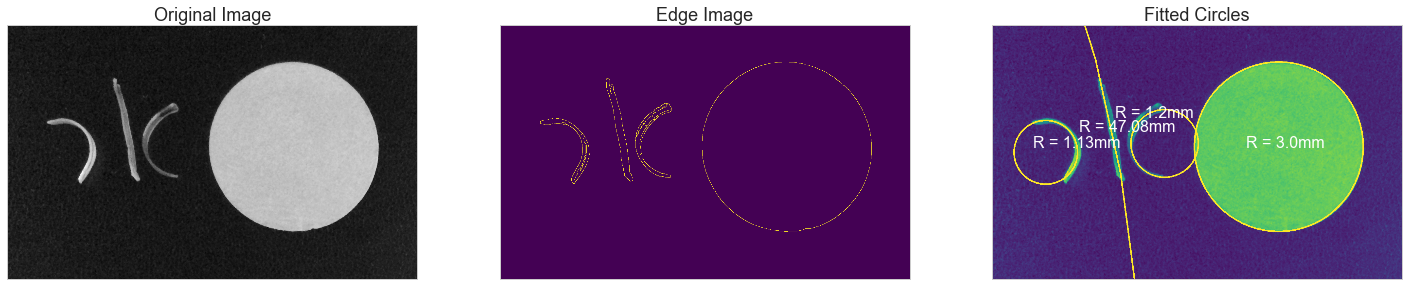

In [10]:
extract_radius_of_curvature('curling_images/small_r_05_340_2_E35_A5.jpg')

## day
### experiment
labeled by some number
* arrays
  * original image
  * fitted image
* metadata
  * cylinder radius
  * pitch
  * thickness
  * width
  * E value
  * A value
  * coil
* derived data
  * x location, y location
  * radii
  * strain